In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

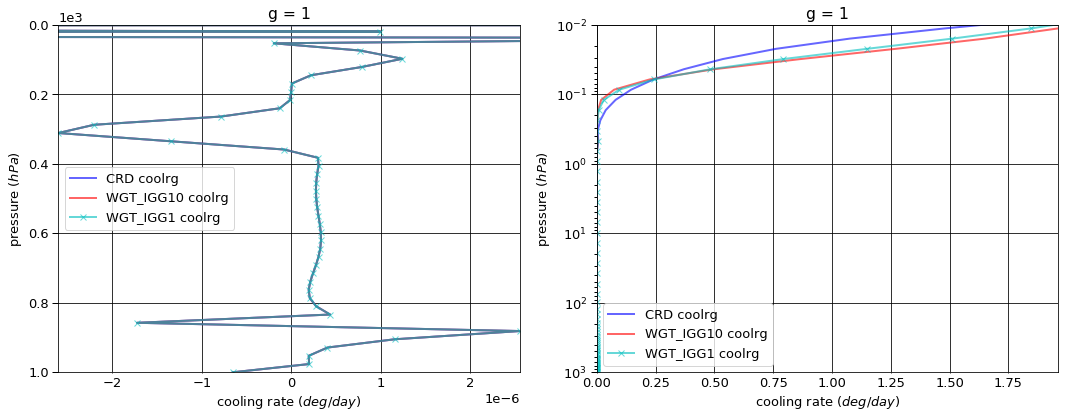

# Figure: cooling rate g-group 2

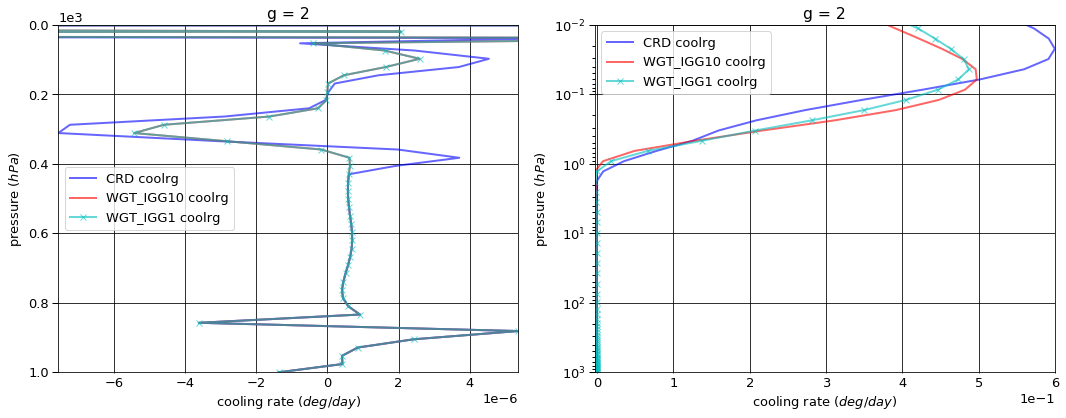

# Figure: cooling rate g-group 3

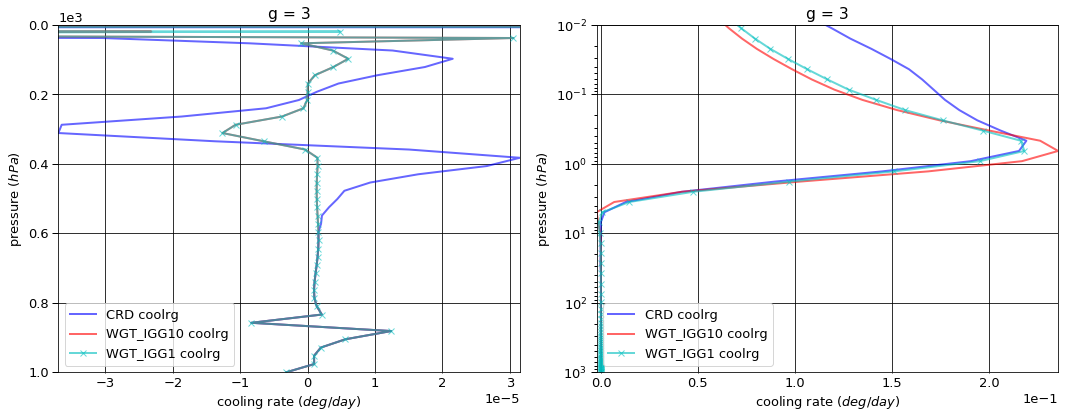

# Figure: cooling rate g-group 4

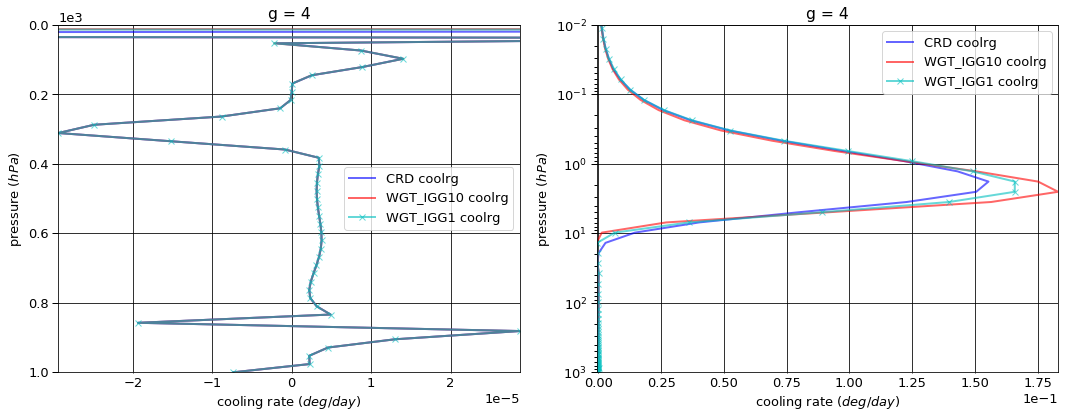

# Figure: cooling rate g-group 5

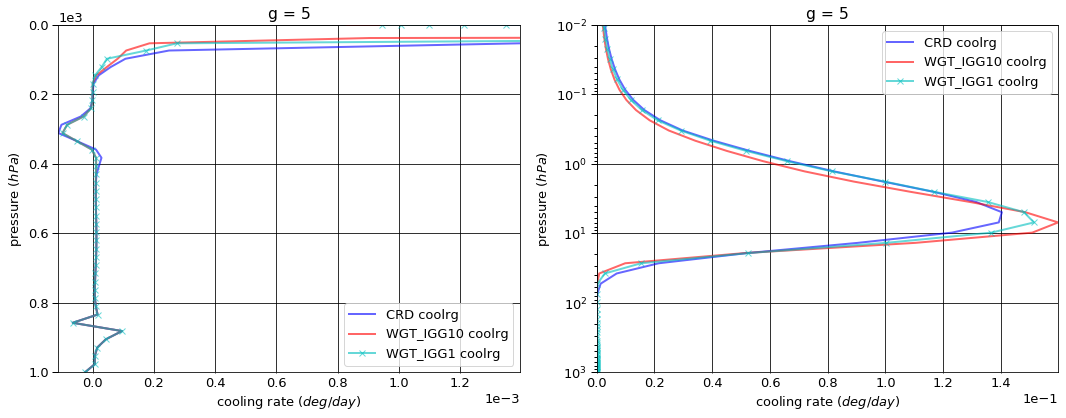

# Figure: cooling rate g-group 6

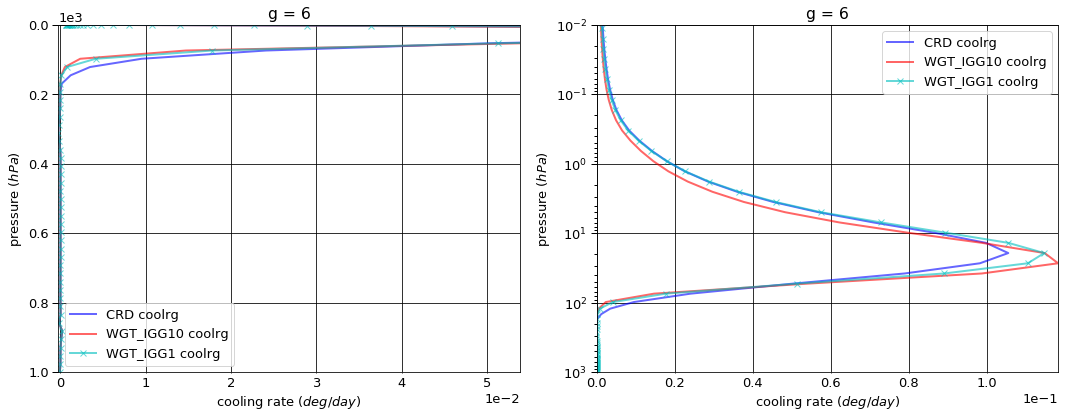

# Figure: cooling rate g-group 7

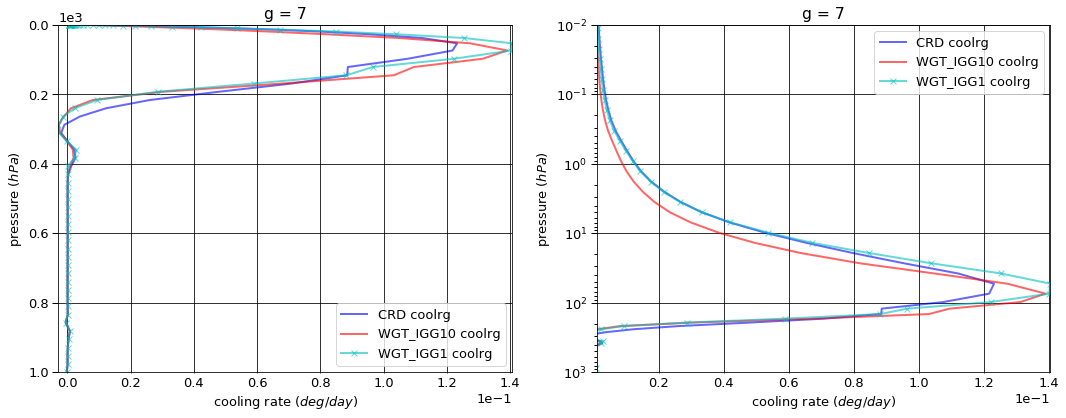

# Figure: cooling rate g-group 8

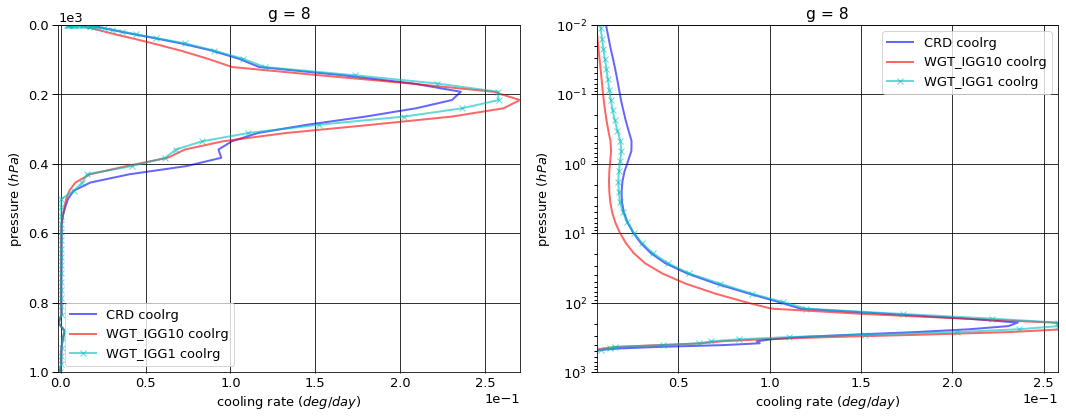

# Figure: cooling rate g-group 9

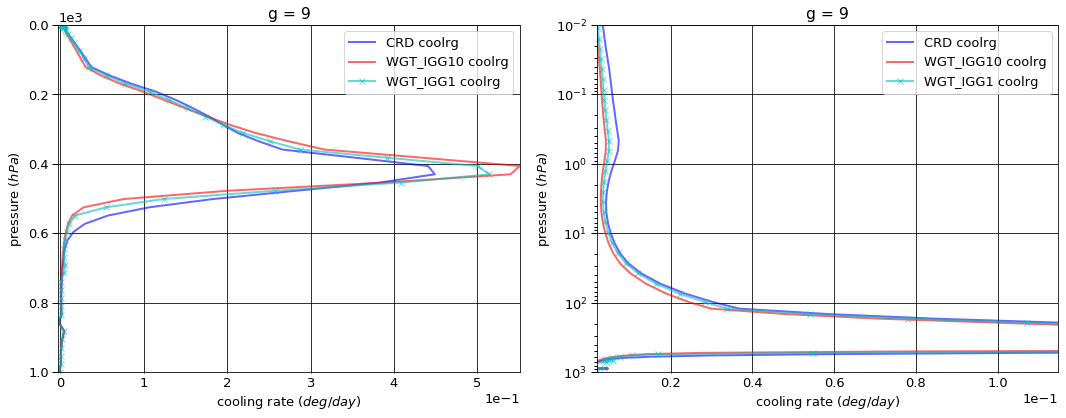

# Figure: cooling rate g-group 10

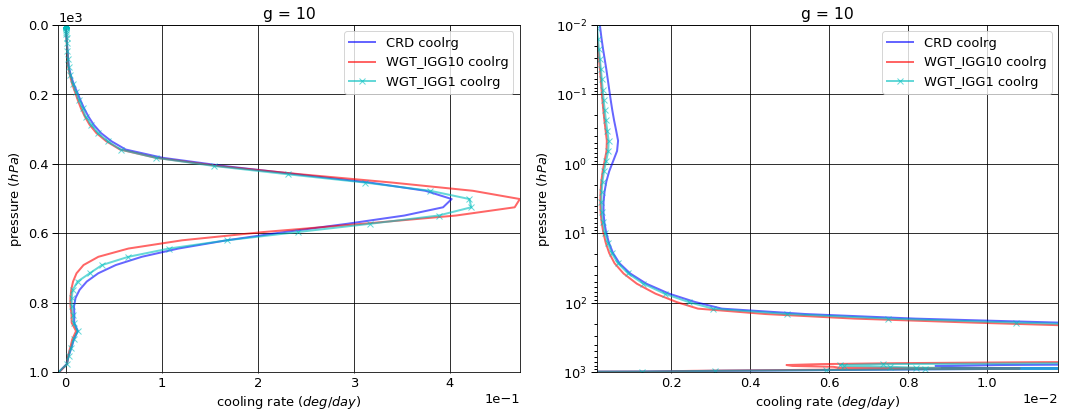

# Figure: cooling rate g-group total

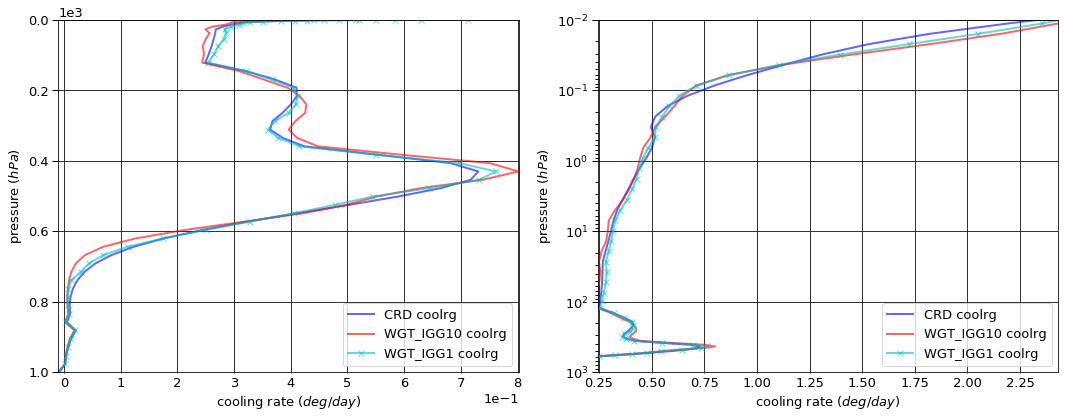

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008384   0.000000  -0.008384
   1013.0   76     -0.009922   0.009924   0.000002
2  0.0      1      -0.019192   0.000000  -0.019192
   1013.0   76     -0.020199   0.020204   0.000005
3  0.0      1      -0.044775   0.000000  -0.044775
   1013.0   76     -0.048502   0.048513   0.000011
4  0.0      1      -0.094326   0.000000  -0.094326
   1013.0   76     -0.114123   0.114148   0.000025
5  0.0      1      -0.287653   0.000000  -0.287653
   1013.0   76     -0.381874   0.381958   0.000084
6  0.0      1      -0.652434   0.000000  -0.652434
   1013.0   76     -0.896578   0.896775   0.000198
7  0.0      1      -2.287980   0.000000  -2.287980
   1013.0   76     -3.115571   3.116259   0.000689
8  0.0      1      -6.663324   0.000000  -6.663324
   1013.0   76     -8.925444   8.927440   0.001997
9  0.0      1     -11.547037   0.000000 -11.547037
   1013.0   76    -14.600303  14.606467   0.006164
10 0.0      1     -10.340870   0.000000 -10.340870
   1013.0   76    -12.148954  12.181340   0.032386


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008434   0.000000  -0.008434
   1013.0   76     -0.009922   0.009924   0.000002
2  0.0      1      -0.019372   0.000000  -0.019372
   1013.0   76     -0.020199   0.020204   0.000005
3  0.0      1      -0.045211   0.000000  -0.045211
   1013.0   76     -0.048502   0.048513   0.000011
4  0.0      1      -0.095423   0.000000  -0.095423
   1013.0   76     -0.114123   0.114148   0.000025
5  0.0      1      -0.288125   0.000000  -0.288125
   1013.0   76     -0.381874   0.381958   0.000084
6  0.0      1      -0.650030   0.000000  -0.650030
   1013.0   76     -0.896578   0.896775   0.000198
7  0.0      1      -2.287463   0.000000  -2.287463
   1013.0   76     -3.115571   3.116259   0.000689
8  0.0      1      -6.630709   0.000000  -6.630709
   1013.0   76     -8.925444   8.927434   0.001990
9  0.0      1     -11.443723   0.000000 -11.443723
   1013.0   76    -14.600303  14.604934   0.004631
10 0.0      1     -10.285697   0.000000 -10.285697
   1013.0   76    -12.148954  12.175280   0.026326


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.008419   0.000000  -0.008419
   1013.0   76     -0.009922   0.009924   0.000002
2  0.0      1      -0.019376   0.000000  -0.019376
   1013.0   76     -0.020199   0.020204   0.000005
3  0.0      1      -0.044837   0.000000  -0.044837
   1013.0   76     -0.048502   0.048513   0.000011
4  0.0      1      -0.095022   0.000000  -0.095022
   1013.0   76     -0.114123   0.114148   0.000025
5  0.0      1      -0.288328   0.000000  -0.288328
   1013.0   76     -0.381874   0.381958   0.000084
6  0.0      1      -0.651260   0.000000  -0.651260
   1013.0   76     -0.896578   0.896775   0.000198
7  0.0      1      -2.284587   0.000000  -2.284587
   1013.0   76     -3.115571   3.116259   0.000689
8  0.0      1      -6.625985   0.000000  -6.625985
   1013.0   76     -8.925444   8.927434   0.001990
9  0.0      1     -11.478379   0.000000 -11.478379
   1013.0   76    -14.600303  14.603656   0.003354
10 0.0      1     -10.336112   0.000000 -10.336112
   1013.0   76    -12.148954  12.180977   0.032023


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1     -4.973110e-05  0.000000 -4.973110e-05
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
2  0.0      1     -1.794000e-04  0.000000 -1.794000e-04
   1013.0   76     0.000000e+00  0.000000 -8.470329e-22
3  0.0      1     -4.361310e-04  0.000000 -4.361310e-04
   1013.0   76    -6.938894e-18  0.000000  0.000000e+00
4  0.0      1     -1.096798e-03  0.000000 -1.096798e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1     -4.714400e-04  0.000000 -4.714400e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
6  0.0      1      2.404200e-03  0.000000  2.404200e-03
   1013.0   76     0.000000e+00  0.000000  2.710505e-20
7  0.0      1      5.172000e-04  0.000000  5.172000e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      3.261530e-02  0.000000  3.261530e-02
   1013.0   76     1.776357e-15 -0.000007 -6.933600e-06
9  0.0      1      1.033140e-01  0.000000  1.033140e-01
   1013.0   76     0.000000e+00 -0.001533 -1.532710e-03
10 0.0      1      5.517300e-02  0.000000  5.517300e-02
   1013.0   76     0.000000e+00 -0.006060 -6.060073e-03


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1     -3.512760e-05  0.000000 -3.512760e-05
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
2  0.0      1     -1.834720e-04  0.000000 -1.834720e-04
   1013.0   76     0.000000e+00  0.000000 -8.470329e-22
3  0.0      1     -6.208700e-05  0.000000 -6.208700e-05
   1013.0   76    -6.938894e-18  0.000000  0.000000e+00
4  0.0      1     -6.964670e-04  0.000000 -6.964670e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1     -6.747600e-04  0.000000 -6.747600e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
6  0.0      1      1.174170e-03  0.000000  1.174170e-03
   1013.0   76     0.000000e+00  0.000000  2.710505e-20
7  0.0      1      3.392800e-03  0.000000  3.392800e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      3.733930e-02  0.000000  3.733930e-02
   1013.0   76     1.776357e-15 -0.000007 -6.933600e-06
9  0.0      1      6.865800e-02  0.000000  6.865800e-02
   1013.0   76     0.000000e+00 -0.002811 -2.810319e-03
10 0.0      1      4.758000e-03  0.000000  4.758000e-03
   1013.0   76     0.000000e+00 -0.000363 -3.634290e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.319128e+00
   1001.112500 75    -6.528382e-07
2  0.000312    1      2.674763e-01
   1001.112500 75    -1.367985e-06
3  0.000312    1      5.349380e-02
   1001.112500 75    -3.166028e-06
4  0.000312    1      3.409586e-05
   1001.112500 75    -7.335164e-06
5  0.000312    1      1.171511e-03
   1001.112500 75    -2.450758e-05
6  0.000312    1      7.027939e-04
   1001.112500 75    -5.742440e-05
7  0.000312    1      6.131115e-04
   1001.112500 75    -2.000944e-04
8  0.000312    1      4.894804e-03
   1001.112500 75    -5.795531e-04
9  0.000312    1      1.659143e-03
   1001.112500 75    -1.763124e-03
10 0.000312    1      5.393805e-05
   1001.112500 75    -7.222832e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.026346e+00
   1001.112500 75    -6.528382e-07
2  0.000312    1      1.666638e-01
   1001.112500 75    -1.367985e-06
3  0.000312    1      2.963762e-02
   1001.112500 75    -3.166028e-06
4  0.000312    1      3.186154e-05
   1001.112500 75    -7.335164e-06
5  0.000312    1      8.297439e-04
   1001.112500 75    -2.450758e-05
6  0.000312    1      5.582990e-04
   1001.112500 75    -5.742440e-05
7  0.000312    1      3.567292e-04
   1001.112500 75    -2.000944e-04
8  0.000312    1      2.615081e-03
   1001.112500 75    -5.778979e-04
9  0.000312    1      9.006670e-04
   1001.112500 75    -1.335577e-03
10 0.000312    1      2.969664e-05
   1001.112500 75    -6.800657e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      2.537117e+00
   1001.112500 75    -6.528382e-07
2  0.000312    1      1.908378e-01
   1001.112500 75    -1.367985e-06
3  0.000312    1      3.235503e-02
   1001.112500 75    -3.166028e-06
4  0.000312    1      3.392546e-05
   1001.112500 75    -7.335164e-06
5  0.000312    1      9.432413e-04
   1001.112500 75    -2.450758e-05
6  0.000312    1      6.866686e-04
   1001.112500 75    -5.742440e-05
7  0.000312    1      5.089095e-04
   1001.112500 75    -2.000944e-04
8  0.000312    1      3.739010e-03
   1001.112500 75    -5.778979e-04
9  0.000312    1      1.073842e-03
   1001.112500 75    -9.740575e-04
10 0.000312    1      3.419379e-05
   1001.112500 75    -7.634731e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.292782e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.008125e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -2.385618e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -2.234312e-06
   1001.112500 75     8.470329e-22
5  0.000312    1     -3.417673e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.444949e-04
   1001.112500 75    -6.776264e-21
7  0.000312    1     -2.563823e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -2.279724e-03
   1001.112500 75     1.655110e-06
9  0.000312    1     -7.584763e-04
   1001.112500 75     4.275468e-04
10 0.000312    1     -2.424141e-05
   1001.112500 75     4.221750e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.782011e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -7.663847e-02
   1001.112500 75     0.000000e+00
3  0.000312    1     -2.113877e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.703930e-07
   1001.112500 75     8.470329e-22
5  0.000312    1     -2.282699e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.612526e-05
   1001.112500 75    -6.776264e-21
7  0.000312    1     -1.042020e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.155794e-03
   1001.112500 75     1.655110e-06
9  0.000312    1     -5.853017e-04
   1001.112500 75     7.890660e-04
10 0.000312    1     -1.974426e-05
   1001.112500 75    -4.118993e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.945976,0.000000,-31.945976
1013.0,76,-40.261468,40.303029,0.041561



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.754186,0.000000,-31.754186
1013.0,76,-40.261468,40.295429,0.033962



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.832306,0.000000,-31.832306
1013.0,76,-40.261468,40.299848,0.038381



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.917902e-01,0.0000,0.19179
1013.0,76,7.105427e-15,-0.0076,-0.00760



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.136704e-01,0.000000,0.113670
1013.0,76,7.105427e-15,-0.003181,-0.003181


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.649227
1001.112500,75,-0.009860



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.227969
1001.112500,75,-0.009009



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.767329
1001.112500,75,-0.009481



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.421258
1001.112500,75,0.000851



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.881898
1001.112500,75,0.000379


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000266,0.000247
2,0.000500,0.000502
3,0.001391,0.001208
4,0.003156,0.002844
5,0.011406,0.009518
6,0.025547,0.022349
7,0.093094,0.077651
8,0.256141,0.222367
9,0.383641,0.363218


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.096164e-16
2,1.309690e-17
3,1.564810e-18
4,4.601703e-18
5,5.682550e-19
6,6.154553e-19
7,7.853808e-20
8,1.002222e-20
9,1.278933e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.096164e-16,NaN,0.000266,0.000247,0.000266,0.000247,1.0
2,1.309690e-17,0.119479,0.000500,0.000502,0.000766,0.000749,1.0
3,1.564810e-18,0.119479,0.001391,0.001208,0.002156,0.001957,1.0
4,4.601703e-18,2.940742,0.003156,0.002844,0.005313,0.004801,30.0
5,5.682550e-19,0.123488,0.011406,0.009518,0.016719,0.014319,30.0
6,6.154553e-19,1.083062,0.025547,0.022349,0.042266,0.036668,300.0
7,7.853808e-20,0.127610,0.093094,0.077651,0.135359,0.114319,300.0
8,1.002222e-20,0.127610,0.256141,0.222367,0.391500,0.336686,300.0
9,1.278933e-21,0.127610,0.383641,0.363218,0.775141,0.699904,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
